In [1]:
import sys
sys.path.append("../../")
from pathlib import Path

import tqdm
import numpy as np
import torch

from frag.mol.mols import Mol
from frag.graph.molgraph import MolGraph, MolGraphDataset, MolGraphDataSetGenerator
from frag.fragmentation.fragmenters import BondFragmenter, AngleFragmenter
from frag.labeling.labelers import BondLabeler, AngleLabeler
from frag.featurization.atom_featurizers import RDKITFingerprint


from frag.graph.message_passing import MessagePassingBonded
from frag.graph.readout import ReadoutJanossyLinear

/net/cci/cschlick/miniconda3/envs/restraintsML/envs/restraintsML6/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder = Path("/dev/shm/cschlick/CODoutput/")
files = [file for file in folder.glob("**/*") if "geo" in file.name and file.suffix==".cif"]

In [3]:
mols = []
debug = False
for file in tqdm.tqdm(files):
  try:
    mol = Mol.from_file_geocif(file)
    mols.append(mol)
  except:
    if debug:
      raise
  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102144/102144 [12:30<00:00, 136.14it/s]


In [4]:
dataset_generator = MolGraphDataSetGenerator(fragmenter=AngleFragmenter(exclude_elements=[]),
                                             atom_featurizer = RDKITFingerprint(),
                                             fragment_labelers={"angle_value":AngleLabeler()},
                                             skip_hydrogens=False)

In [5]:
dataset = dataset_generator(mols)

  0%|▍                                                                                                                         | 324/97296 [00:04<19:37, 82.35it/s][00:31:19] 

****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
****

 11%|████████████▋                                                                                                           | 10259/97296 [02:15<24:56, 58.18it/s][00:33:31] 

****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
****

 28%|█████████████████████████████████▊                                                                                      | 27416/972

In [72]:
# set up dataset, train/test split
dataset_train, dataset_test = dataset.train_test_split(test_fraction=0.1)
batches = list(dataset_train.batches(n_batches=12))

In [73]:
label_name = "angle_value"
fragment_size = 3
hidden_units = 64


atom_feature_shape = tuple(dataset[0].fragment_graph.nodes["atom"].data["h0"].shape)
message_passing = MessagePassingBonded(feature_units=atom_feature_shape[1],
                                       hidden_units=hidden_units,
                                       nlayers=4,
                                       )


readout = ReadoutJanossyLinear(hidden_units*fragment_size,
                               hidden_units*fragment_size,
                               1,
                               n_hid_layers=3,
                               label_name=label_name,
                               fragment_size=fragment_size)

model = torch.nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
metric = torch.nn.MSELoss()

In [74]:
# Training loop
gpuid = 0


if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

epoch_losses = []
n_epoch=1000

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(torch.deg2rad(g.nodes["fragment"].data[label_name]),
                  g.nodes["fragment"].data[label_name+"_pred"])
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))

 32%|███████████████████████████████████████▎                                                                                   | 320/1000 [07:40<16:17,  1.44s/it]


KeyboardInterrupt: 

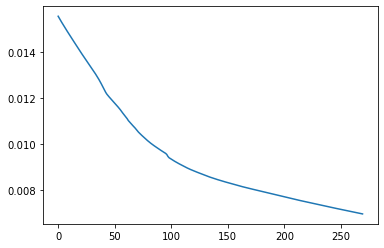

In [75]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses[50:])

In [76]:
test_batch.nodes["fragment"].data[label_name]

tensor([[116.4927],
        [112.9584],
        [111.5373],
        ...,
        [112.0296],
        [119.9949],
        [119.9714]])

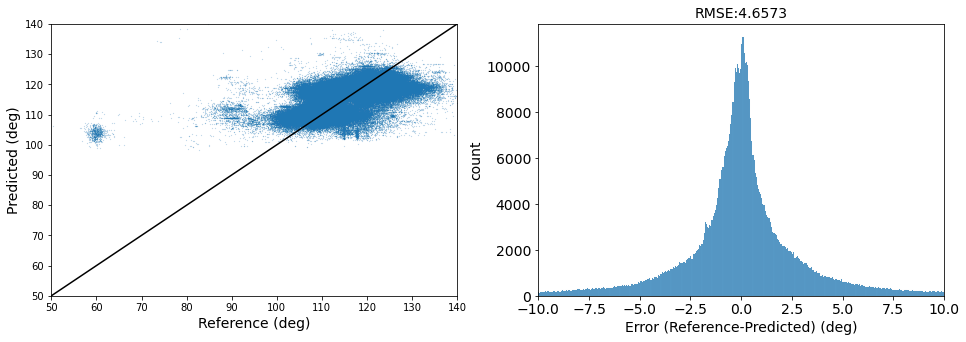

In [77]:
from frag.utils.torch import to_np, to_torch
from frag.utils.plotting import plot_geom_eval

if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test.fragment_graph)
a,b = (test_batch.nodes["fragment"].data[label_name], 
       torch.rad2deg(test_batch.nodes["fragment"].data[label_name+"_pred"]))
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

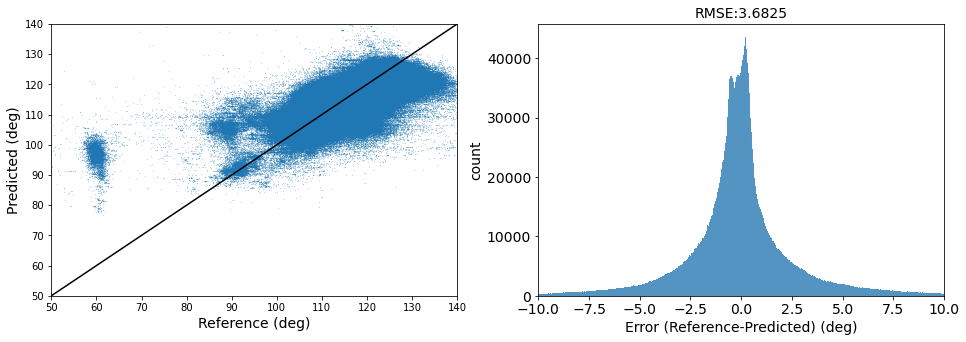

In [44]:
from frag.utils.torch import to_np, to_torch
from frag.utils.plotting import plot_geom_eval

if gpuid is not None:
  model = model.to("cpu")
train_batch = model(dataset_train.fragment_graph)
a,b = (train_batch.nodes["fragment"].data[label_name], 
       train_batch.nodes["fragment"].data[label_name+"_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

In [24]:
dataset_generator.pretrained_models["predictor"] = model

In [25]:
file_pkl = "../../pretrained/gnn_angles_dsgen.pkl"
dataset_generator.to_file_pickle(file_pkl)

# Test inference

In [14]:
ds_gen = MolGraphDataSetGenerator.from_file_pickle(file_pkl)

In [22]:
mol_file = "/dev/shm/cschlick/CODoutput/cif/8/10/51/8105185_000_geo.cif"
mol = Mol.from_file_geocif(mol_file)
ds_inf = ds_gen(mol)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.08it/s]


In [15]:
model = ds_gen.pretrained_models["predictor"]
#pred_graph = model(ds_inf.fragment_graph)

KeyError: 'predictor'

In [19]:
pred_graph.nodes["fragment"].data[label_name+"_pred"]

NameError: name 'pred_graph' is not defined

In [17]:
model = torch.load("../../pretrained/bak/angle_model.pkl")

In [22]:
dataset.fragment_graph.nodes["fragment"].data.keys()

dict_keys(['mol_atom_index', 'graph_node_index', 'angle_value'])

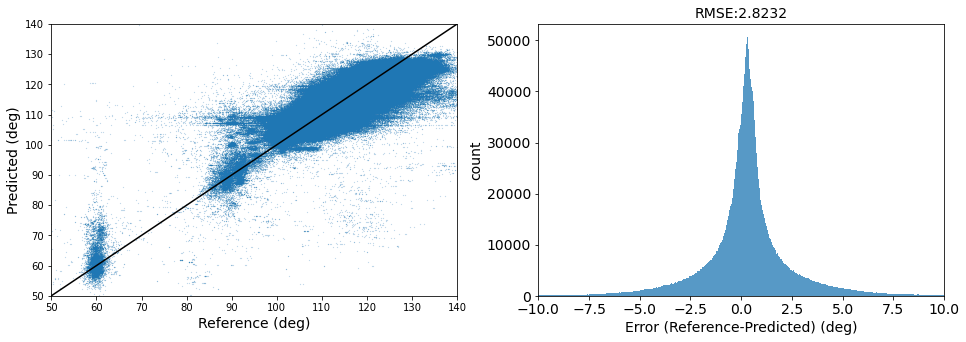

In [23]:
from frag.utils.torch import to_np, to_torch
from frag.utils.plotting import plot_geom_eval

if gpuid is not None:
  model = model.to("cpu")
  
pred_graph = model(dataset.fragment_graph)
a,b = (dataset.fragment_graph.nodes["fragment"].data[label_name], 
       pred_graph.nodes["fragment"].data[label_name+"_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")